<a href="https://colab.research.google.com/github/Iflgit/GB_CV/blob/main/l8/8_1_Generation_VAE_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Синтез изображений. Часть 1. Вариационный Автоэнкодер (VAE)

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

## Загрузка и подготовка датасета MNIST

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11501568/11490434 [==============================] - 0s 0us/step


## Визуализация датасета MNIST

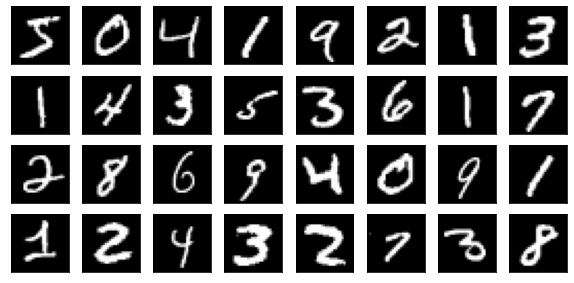

In [4]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    for j in range(samples.shape[0]):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

plot_digits(train_x[:32, ...])

## Создание Энкодера и Декодера

In [5]:
class Encoder(tf.keras.Model):
    
    def __init__(self):
        super().__init__()

        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc_mean = tf.keras.layers.Dense(2, activation=None)
        self.fc_log_sigma = tf.keras.layers.Dense(2, activation=None)
        self.max_pool = tf.keras.layers.MaxPool2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)

        z_mean = self.fc_mean(out)
        z_log_sigma = self.fc_log_sigma(out)
        
        rnd = tf.random.normal(tf.shape(z_mean))
        z = z_mean + tf.exp(z_log_sigma) * rnd
        return z_mean, z_log_sigma, z

class Decoder(tf.keras.Model):
    
    def __init__(self):
        super().__init__()

        self.fc1 = tf.keras.layers.Dense(7*7*64, activation='relu')
        self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), padding='valid', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(1, (5, 5), padding='valid', activation='sigmoid')
        self.upsample = tf.keras.layers.UpSampling2D((2, 2))

    def call(self, inp):
        batch_size = inp.shape[0]

        out = self.fc1(inp)
        out = tf.reshape(out, (batch_size, 7, 7, 64))
        out = self.upsample(out)
        out = self.conv1(out)
        out = self.upsample(out)
        out = self.conv2(out)
        out = self.upsample(out)
        out = self.conv3(out)
        return out

encoder = Encoder()
decoder = Decoder()

## Инференс и функция потерь для VAE

In [6]:
def vae(inp):
    _, _, z = encoder(inp)
    out = decoder(z)
    return out

def vae_loss(inp, target):
        z_mean, z_log_sigma, z = encoder(inp)
        pred = decoder(z)
        
        mse_loss = tf.reduce_sum(tf.square(pred - target), axis=[1, 2, 3])
        tmp = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
        KL_loss = -0.5 * tf.reduce_sum(tmp, axis=-1)
        return tf.reduce_mean(mse_loss + KL_loss)

## Подготовка пайплайна данных и оптимизатора

In [7]:
NUM_EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 0.001

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

## Обучение VAE

[Epoch  0] Train Loss: 29.3545


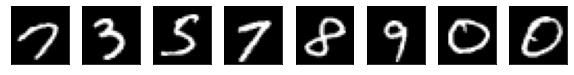

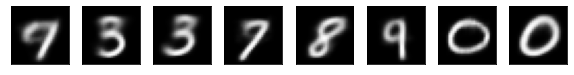

[Epoch  1] Train Loss: 30.3319


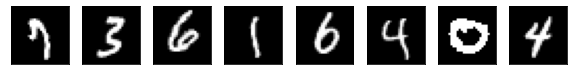

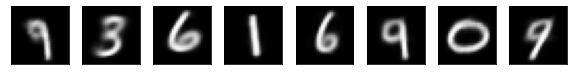

[Epoch  2] Train Loss: 31.5148


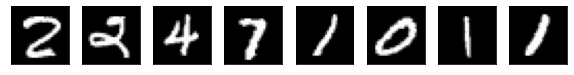

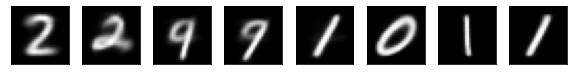

[Epoch  3] Train Loss: 32.6016


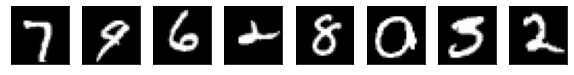

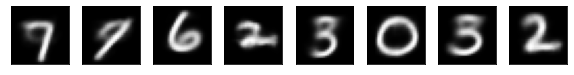

[Epoch  4] Train Loss: 29.5850


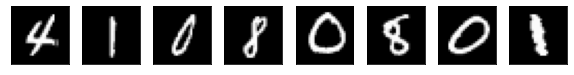

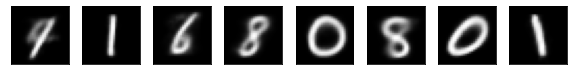

[Epoch  5] Train Loss: 30.1383


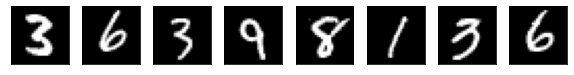

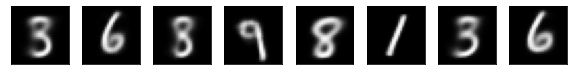

[Epoch  6] Train Loss: 29.4929


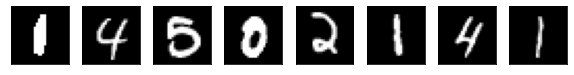

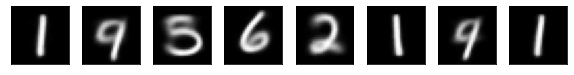

[Epoch  7] Train Loss: 31.0655


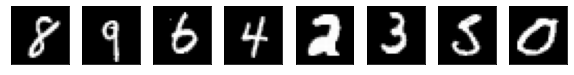

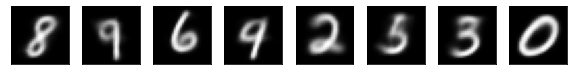

[Epoch  8] Train Loss: 29.8193


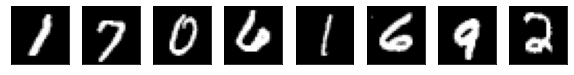

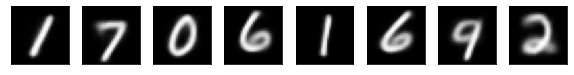

[Epoch  9] Train Loss: 31.3233


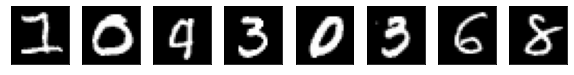

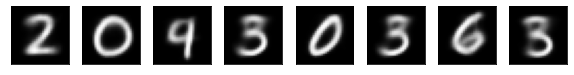

[Epoch 10] Train Loss: 28.7979


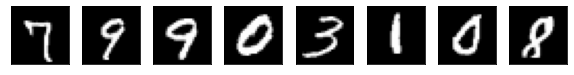

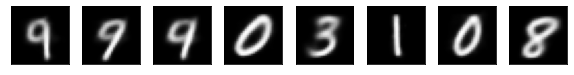

[Epoch 11] Train Loss: 29.0374


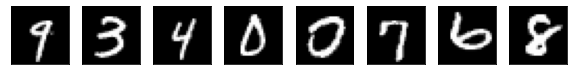

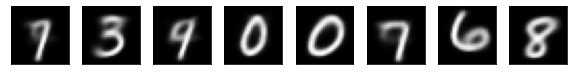

[Epoch 12] Train Loss: 32.5861


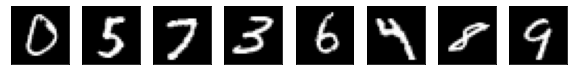

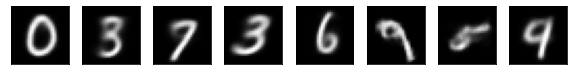

[Epoch 13] Train Loss: 32.0441


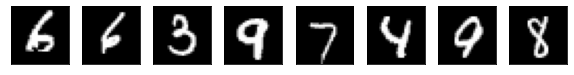

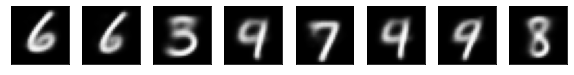

[Epoch 14] Train Loss: 29.8660


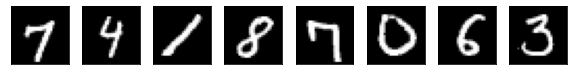

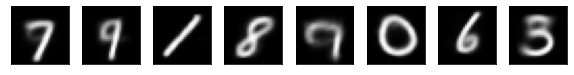

[Epoch 15] Train Loss: 29.0765


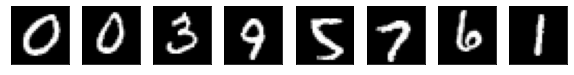

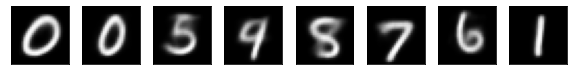

[Epoch 16] Train Loss: 32.7923


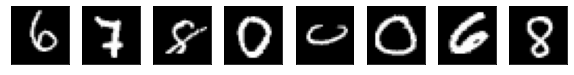

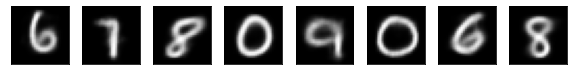

[Epoch 17] Train Loss: 31.5256


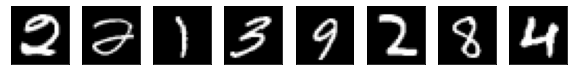

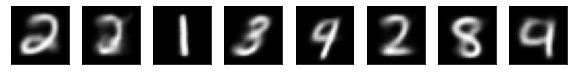

[Epoch 18] Train Loss: 31.3807


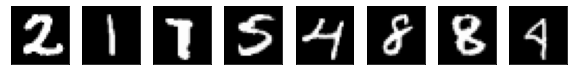

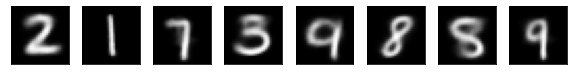

[Epoch 19] Train Loss: 30.1201


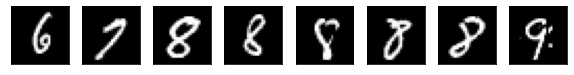

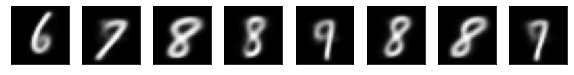

[Epoch 20] Train Loss: 29.7427


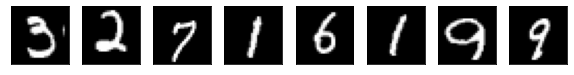

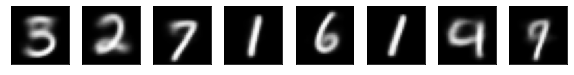

[Epoch 21] Train Loss: 31.8362


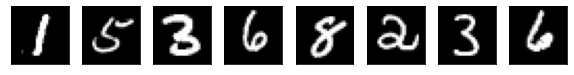

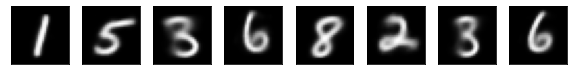

[Epoch 22] Train Loss: 30.3686


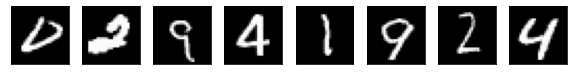

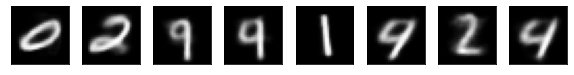

[Epoch 23] Train Loss: 30.0545


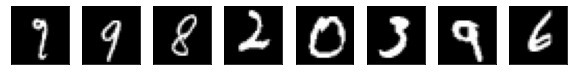

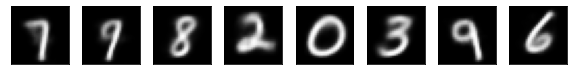

[Epoch 24] Train Loss: 30.1979


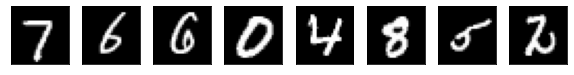

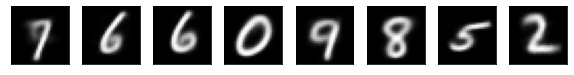

In [11]:
for e in range(NUM_EPOCHS):
    for batch in train_ds:   
        with tf.GradientTape() as tape:
            loss_value = vae_loss(batch, batch)
        train_vars = encoder.variables + decoder.variables
        grads = tape.gradient(loss_value, train_vars)
        optimizer.apply_gradients(zip(grads, train_vars))

    print("[Epoch %2d] Train Loss: %.4f" % (e, loss_value.numpy()))

    batch_pred = vae(batch[0:8])
    plot_digits(batch[0:8])
    plot_digits(batch_pred)

## Применение VAE на тестовых образцах

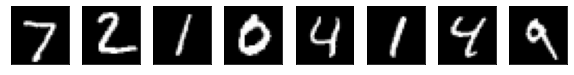

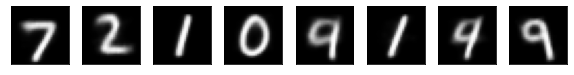

In [12]:
text_x_pred = vae(test_x[0:8])

plot_digits(test_x[0:8])
plot_digits(text_x_pred)

## VAE в режиме синтеза. Интерполяция в латентном пространстве

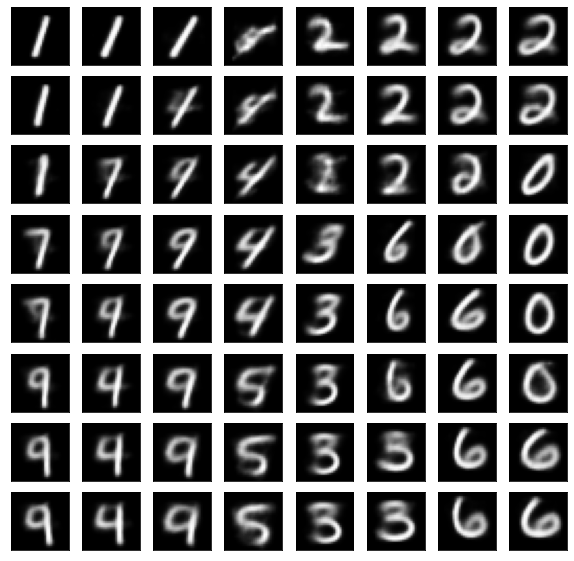

In [13]:
generated_list = []

for xi in np.linspace(-1, 1, 8):
    for xj in np.linspace(-1, 1, 8):
        generated = decoder(np.array([[xi, xj]]).astype(np.float32))
        generated_list.append(generated)

plot_digits(np.concatenate(generated_list))